In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
#import cellpose
#from cellpose import models, utils, io, plot
#from cellpose.io import imread
import math
from scipy import stats
from imageio import volread, volwrite, volsave, mvolwrite, imwrite, imread
from scipy.ndimage import binary_fill_holes
import time, os, sys
import tifffile

In [2]:
import pandas as pd
from scipy import ndimage
import re
from skimage import data
from skimage.filters import try_all_threshold
from skimage.filters import threshold_isodata
from skimage.filters import threshold_otsu, threshold_local
from sklearn.linear_model import LinearRegression
from skimage import filters
from skimage import data, filters
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sns

from tqdm import tqdm
import time

# Define the fuction for reading in your image and segmentation files

In [4]:
#set your directory
RGB_fold = r'C:\Users\abockhughes\Box\Macleod Lab\Images Imaging Pictures Microscopy\Image work up folder\240411 all WT 6hr UT ATF4 heps\half size and rgb'
stack_fold = r'C:\Users\abockhughes\Box\Macleod Lab\Images Imaging Pictures Microscopy\Image work up folder\240411 all WT 6hr UT ATF4 heps\all the same channels and half size'
os.listdir(RGB_fold)

['10a_tile_merging_ICC103.tif',
 '10a_tile_merging_ICC103_seg.npy',
 '10b_tile_Merging_ICC103.tif',
 '10b_tile_Merging_ICC103_seg.npy',
 '10c_tile_Merging_ICC103.tif',
 '10c_tile_Merging_ICC103_seg.npy',
 '10d_tile_Merging_ICC103.tif',
 '10d_tile_Merging_ICC103_seg.npy',
 '1a_tile_Merging_ICC103.tif',
 '1a_tile_Merging_ICC103_seg.npy',
 '1b_tile_Merging_ICC103.tif',
 '1b_tile_Merging_ICC103_seg.npy',
 '1c_tile_Merging_ICC103.tif',
 '1c_tile_Merging_ICC103_seg.npy',
 '1f_tile_Merging_ICC103.tif',
 '1f_tile_Merging_ICC103_seg.npy',
 '2a_tile_Merged_ICC116.tif',
 '2a_tile_Merged_ICC116_seg.npy',
 '2b_tile_Merged_ICC116.tif',
 '2b_tile_Merged_ICC116_seg.npy',
 '5a_tile_Merging_ICC111.tif',
 '5a_tile_Merging_ICC111_seg.npy',
 '5b_tile_Merging_ICC111.tif',
 '5b_tile_Merging_ICC111_seg.npy',
 '5c_tile_Merging_ICC111.tif',
 '5c_tile_Merging_ICC111_seg.npy',
 '5d_tile_Merging_ICC111.tif',
 '5d_tile_Merging_ICC111_seg.npy',
 '5e_tile_Merging_ICC111.tif',
 '5e_tile_Merging_ICC111_seg.npy',
 '5f_t

In [4]:
#Define function for reading in all the segmented data as well as the actual images you want to analyze
def read_in_imgs_and_seg(img_dir, seg_dir):
    data_list = []

    for filename in os.listdir(img_dir):
        # Check if the file is an image (you can modify this condition as needed)
        if filename.lower().endswith(('.tif', '.jpg', '.jpeg')):
            # Read image data (you may need to adjust this based on your data format)
            image_data = volread(os.path.join(img_dir, filename))

            # Check if there is a corresponding segmentation file
            filename_seg = filename.replace(('.tif'), '_seg.npy')
            seg_filepath = os.path.join(seg_dir, filename_seg)
            
            if os.path.exists(seg_filepath):
                # Read segmentation data
                seg_data = np.load(seg_filepath, allow_pickle=True).item()
                    #if not 'img' in data.keys():                             #this is for if you only want to upload the seg.npys
                        #data['img']=volread(os.path.join(root_dir, filename))

                 # Extract relevant information from the image and _seg.npy data
            # For example, you can extract masks, outlines, flows, estimated diameters, etc.
            masks = seg_data['masks']
            outlines = seg_data.get('outlines', None)
           
            
            # Store the extracted information in a dictionary
            data_dict = {
                'image_file': filename,
                'image_data': image_data,
                'masks': masks,
                'outlines': outlines,
                
            }
            
            # Append the dictionary to the data list
            data_list.append(data_dict)
            
    return data_list

### Read in your images, check that they look correct and then create lists for lipid quantification 

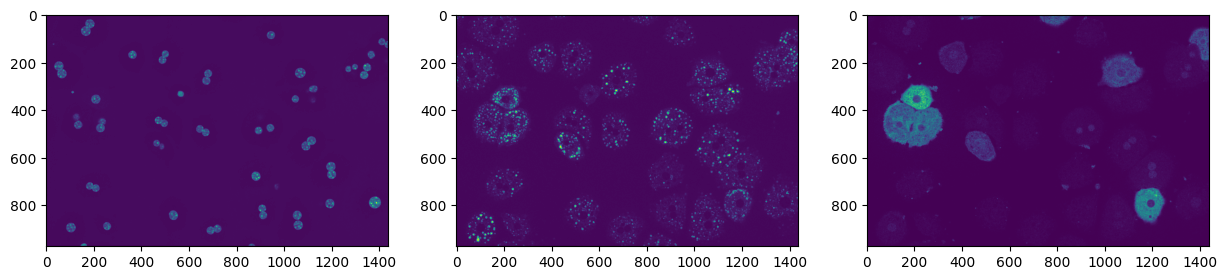

In [5]:
#read in your data from the seg folder and the real images folder
img_dat = read_in_imgs_and_seg(stack_fold, RGB_fold)

#test the read in
#plt.imshow(img_dat[0]['masks'])

#test it a different way 
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].imshow(img_dat[0]['image_data'][0])
axs[1].imshow(img_dat[0]['image_data'][1])
axs[2].imshow(img_dat[0]['image_data'][2])

In [6]:
from multiprocessing import Pool

In [9]:
import workers
help(workers)

Help on module workers:

NAME
    workers

FUNCTIONS
    ATF4_analysis(img, cutoff=0.95)
    
    ATF4_parallel(img_dat, n_processes=48, progress_bar=None, **kwargs)

FILE
    c:\users\abockhughes\box\macleod lab\jupyternotebooks\240412 6hr ut heps\workers.py




In [10]:
help(ndimage)

Help on package scipy.ndimage in scipy:

NAME
    scipy.ndimage

DESCRIPTION
    Multidimensional image processing (:mod:`scipy.ndimage`)
    
    .. currentmodule:: scipy.ndimage
    
    This package contains various functions for multidimensional image
    processing.
    
    
    Filters
    
    .. autosummary::
       :toctree: generated/
    
       convolve - Multidimensional convolution
       convolve1d - 1-D convolution along the given axis
       correlate - Multidimensional correlation
       correlate1d - 1-D correlation along the given axis
       gaussian_filter
       gaussian_filter1d
       gaussian_gradient_magnitude
       gaussian_laplace
       generic_filter - Multidimensional filter using a given function
       generic_filter1d - 1-D generic filter along the given axis
       generic_gradient_magnitude
       generic_laplace
       laplace - N-D Laplace filter based on approximate second derivatives
       maximum_filter
       maximum_filter1d
       median_

In [31]:
from workers import ATF4_analysis, ATF4_parallel
from functools import partial

out=ATF4_parallel(img_dat, progress_bar=tqdm, cutoff=0.95)
#ATF4_cutoff=partial(ATF4_analysis, cutoff=0.95)

doing ATF4 analysis: 100%|██████████| 25/25 [02:09<00:00,  5.16s/it]


In [32]:
mean_ATF4_list, lipid_mean_list, lipid_percent_list = [np.concatenate([x[i] for x in out]) for i in range(3)]

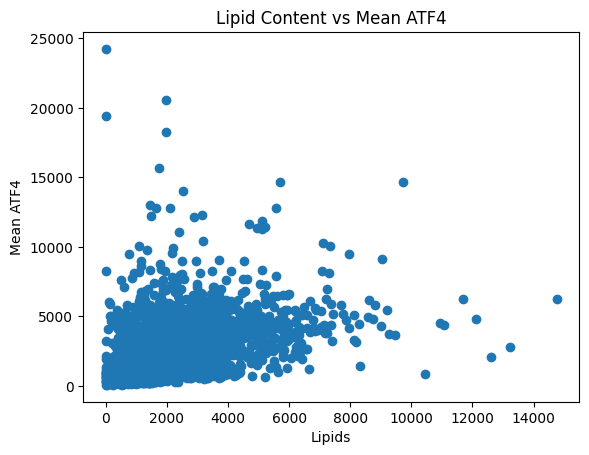

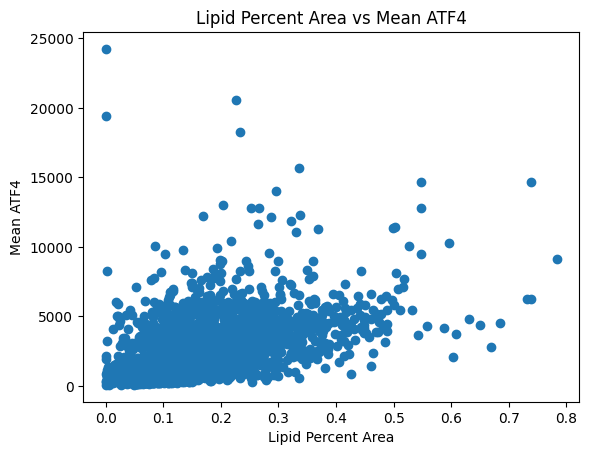

In [33]:
plt.scatter(lipid_mean_list, mean_ATF4_list,)
plt.xlabel('Lipids')
plt.ylabel('Mean ATF4')
plt.title('Lipid Content vs Mean ATF4')
plt.show()

plt.scatter(lipid_percent_list, mean_ATF4_list,)
plt.xlabel('Lipid Percent Area')
plt.ylabel('Mean ATF4')
plt.title('Lipid Percent Area vs Mean ATF4')
plt.show()

In [24]:
out[0]

([212.52065439672802,
  388.3141043723554,
  2233.002921535893,
  4342.682833217027,
  412.4243624487527,
  320.47569444444446,
  1495.9715578043545,
  479.3025857519789,
  3465.9968452750823,
  268.28720985315016,
  407.59088680016345,
  319.9436219530432,
  11335.4,
  6797.79380424036,
  424.95646324399956,
  7089.648011536969,
  483.8934735816107,
  271.603021590845,
  424.0824719755423,
  2806.295242611032,
  645.0126829642118,
  355.55749305029065,
  391.7651815761716,
  403.0074135853952,
  8277.907930542957,
  293.9124601286011,
  445.7191981681597,
  273.8465593784684,
  566.5248749670966,
  279.1024976233688,
  279.53883196147603,
  284.33641536273115,
  277.9171989590726,
  4238.961577479077,
  734.5955237655745,
  592.5207136840493,
  503.4982905982906],
 [502.1562372188139,
  484.79770803949225,
  1007.1656928213689,
  853.2274947662247,
  362.71238968799946,
  661.4405753968254,
  1224.6084023305734,
  593.9133509234829,
  1146.3950575976291,
  1358.397063003316,
  1651.96

In [25]:
np.concatenate([x[0] for x in out])

array([ 212.5206544 ,  388.31410437, 2233.00292154, ...,  767.88999378,
        780.81786942,  747.07393732])

In [11]:
help(ATF4_parallel)

Help on function ATF4_parallel in module workers:

ATF4_parallel(img_dat, n_processes=48, progress_bar=None, **kwargs)



In [14]:
def kwargs_checker(x, **kwargs):
    print('x:', x)
    print('kwargs:', kwargs)
    nested_function(**kwargs)


kwargs_checker(5, kwarg1=5, otherthing='gel')

x: 5
kwargs: {'kwarg1': 5, 'otherthing': 'gel'}


In [13]:
progress_bar=tqdm

progress_bar=lambda x, **progress_kwargs: x

In [14]:
progress_bar(5, a=4)

5

In [20]:
p=Pool(processes=48)
multi_dataset=img_dat*20
out=[x for x in tqdm(p.imap(ATF4_cutoff, multi_dataset), total=len(multi_dataset))]
p.close()

100%|██████████| 500/500 [06:09<00:00,  1.35it/s]


In [8]:
def ATF4_analysis_notebook(img):
    lipid_mean_list = []
    mean_ATF4_list = []
    lipid_percent_list = []
    
    #set threshold for lipids (you can either do this with a quantile or a threshold)
    #lipid_cutoff = threshold_isodata(test_img['image_data'][1])
    lipid_cutoff=np.quantile(img['image_data'][1], 0.95)

    #this code is creating a binary mask of the lipids
    lipids_mask = img['image_data'][1] > lipid_cutoff

    #this code is basically "clear outside' in imagej that clears the outside of all the lipids while keeping the pixel values
    lipids = np.where(img['image_data'][1] > lipid_cutoff, img['image_data'][1], 0)

    # Iterate over each mask
    for mask_label in range(1, img['masks'].max() + 1):

        # Calculate mean ATF4 for the current mask
        mean_ATF4 = ndimage.mean(img['image_data'][2], labels=img['masks'], index=mask_label)
        lipid_mean_per_cell=ndimage.mean(lipids, labels=img['masks'], index=mask_label)
        
        lipid_percent_area=ndimage.mean(lipids_mask, labels=img['masks'], index=mask_label)
        
        lipid_sum = ndimage.sum_labels(lipids, labels=img['masks'], index=mask_label)
        sum_ATF4 = ndimage.sum(img['image_data'][2], labels=img['masks'], index=mask_label)
        
        # Append mean ATF4 to the list for the current image
        mean_ATF4_list.append(mean_ATF4)
        lipid_mean_list.append(lipid_mean_per_cell)
        lipid_percent_list.append(lipid_percent_area)
        
    return mean_ATF4_list, lipid_mean_list, lipid_percent_list

In [23]:
out=[x for x in range(10)]

out=[]
for x in range(10):
    out.append(x)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [25]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [15]:
for i in tqdm(range(100)):
    time.sleep(0.1)

100%|██████████| 100/100 [00:10<00:00,  9.16it/s]


In [34]:
def passthrough(x):
    return x

[4,2]

[4, 2]

In [30]:
# what is a lambda function

def square_function(x):
    return x**2

square_lambda = lambda x: x**2

square_lambda(4)

16

In [ ]:
%%time
#test one set of images image first

#condition = lambda img_dat: '5' in img_dat['image_file']
condition = lambda img_dat: re.match(r'^2[a-zA-Z]_tile_', img_dat['image_file']) is not None

lipid_mean_list = []
mean_ATF4_list = []
lipid_percent_list = []

# Assuming img_dat is your data
for img in img_dat:
    # Check if the image meets the condition
    if condition(img):

        #set threshold for lipids (you can either do this with a quantile or a threshold)
        #lipid_cutoff = threshold_isodata(test_img['image_data'][1])
        lipid_cutoff=np.quantile(img['image_data'][1], 0.95)

        #this code is creating a binary mask of the lipids
        lipids_mask = img['image_data'][1] > lipid_cutoff

        #this code is basically "clear outside' in imagej that clears the outside of all the lipids while keeping the pixel values
        lipids = np.where(img['image_data'][1] > lipid_cutoff, img['image_data'][1], 0)

        # Iterate over each mask
        for mask_label in range(1, img['masks'].max() + 1):

            # Calculate mean ATF4 for the current mask
            mean_ATF4 = ndimage.mean(img['image_data'][2], labels=img['masks'], index=mask_label)
            lipid_mean_per_cell=ndimage.mean(lipids, labels=img['masks'], index=mask_label)
            
            lipid_percent_area=ndimage.mean(lipids_mask, labels=img['masks'], index=mask_label)
            
            lipid_sum = ndimage.sum_labels(lipids, labels=img['masks'], index=mask_label)
            sum_ATF4 = ndimage.sum(img['image_data'][2], labels=img['masks'], index=mask_label)
            

            # Append mean ATF4 to the list for the current image
            mean_ATF4_list.append(mean_ATF4)
            lipid_mean_list.append(lipid_mean_per_cell)
            lipid_percent_list.append(lipid_percent_area)
            

plt.scatter(lipid_mean_list, mean_ATF4_list,)
plt.xlabel('Lipids')
plt.ylabel('Mean ATF4')
plt.title('Lipid Content vs Mean ATF4')
plt.show()

plt.scatter(lipid_percent_list, mean_ATF4_list,)
plt.xlabel('Lipid Percent Area')
plt.ylabel('Mean ATF4')
plt.title('Lipid Percent Area vs Mean ATF4')
plt.show()

In [30]:
%%time
#test one set of images image first

#condition = lambda img_dat: '5' in img_dat['image_file']
condition = lambda img_dat: re.match(r'^2[a-zA-Z]_tile_', img_dat['image_file']) is not None

lipid_mean_list = []
mean_ATF4_list = []
lipid_percent_list = []

# Assuming img_dat is your data
for img in img_dat:
    # Check if the image meets the condition
    if condition(img):

        #set threshold for lipids (you can either do this with a quantile or a threshold)
        #lipid_cutoff = threshold_isodata(test_img['image_data'][1])
        lipid_cutoff=np.quantile(img['image_data'][1], 0.95)

        #this code is creating a binary mask of the lipids
        lipids_mask = img['image_data'][1] > lipid_cutoff

        #this code is basically "clear outside' in imagej that clears the outside of all the lipids while keeping the pixel values
        lipids = np.where(img['image_data'][1] > lipid_cutoff, img['image_data'][1], 0)

        # Iterate over each mask
        for mask_label in range(1, img['masks'].max() + 1):

            # Calculate mean ATF4 for the current mask
            mean_ATF4 = ndimage.mean(img['image_data'][2], labels=img['masks'], index=mask_label)
            lipid_mean_per_cell=ndimage.mean(lipids, labels=img['masks'], index=mask_label)
            
            lipid_percent_area=ndimage.mean(lipids_mask, labels=img['masks'], index=mask_label)
            
            lipid_sum = ndimage.sum_labels(lipids, labels=img['masks'], index=mask_label)
            sum_ATF4 = ndimage.sum(img['image_data'][2], labels=img['masks'], index=mask_label)
            

            # Append mean ATF4 to the list for the current image
            mean_ATF4_list.append(mean_ATF4)
            lipid_mean_list.append(lipid_mean_per_cell)
            lipid_percent_list.append(lipid_percent_area)
            

plt.scatter(lipid_mean_list, mean_ATF4_list,)
plt.xlabel('Lipids')
plt.ylabel('Mean ATF4')
plt.title('Lipid Content vs Mean ATF4')
plt.show()

plt.scatter(lipid_percent_list, mean_ATF4_list,)
plt.xlabel('Lipid Percent Area')
plt.ylabel('Mean ATF4')
plt.title('Lipid Percent Area vs Mean ATF4')
plt.show()

KeyboardInterrupt: 

# Run on all images in folder

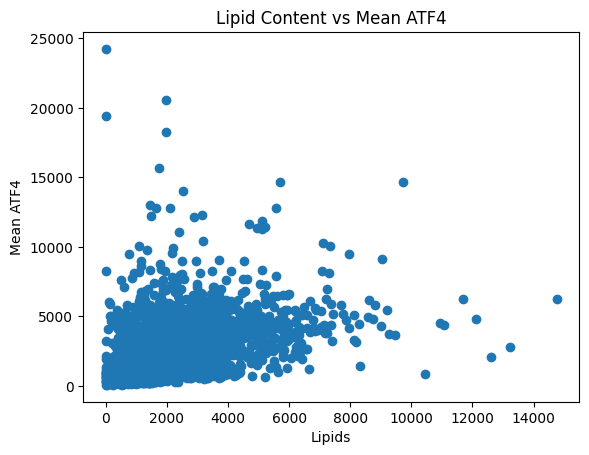

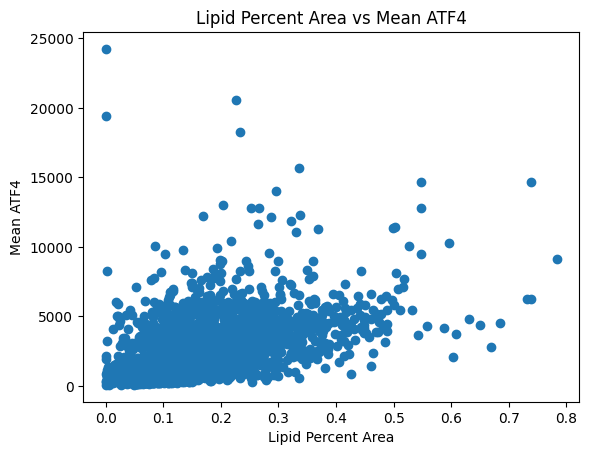

CPU times: total: 2min 28s
Wall time: 2min 28s


In [11]:
%%time
# Initialize empty lists to store mean_ATF4 and lipid_percentarea for each mask
lipid_mean_list = []
mean_ATF4_list = []
lipid_percent_list = []

for img in img_dat:

    #set threshold for lipids (you can either do this with a quantile or a threshold)
    #lipid_cutoff = threshold_isodata(test_img['image_data'][1])
    lipid_cutoff=np.quantile(img['image_data'][1], 0.95)
   
    #this code is creating a binary mask of the lipids
    lipids_mask = img['image_data'][1] > lipid_cutoff
    
    #this code is basically "clear outside' in imagej that clears the outside of all the lipids while keeping the pixel values
    lipids = np.where(img['image_data'][1] > lipid_cutoff, img['image_data'][1], 0)
    
    # Iterate over each mask
    for mask_label in range(1, img['masks'].max() + 1):
        
        # Calculate mean ATF4 for the current mask
        mean_ATF4 = ndimage.mean(img['image_data'][2], labels=img['masks'], index=mask_label)
        
        #calculate mean lipid per cell taking pixel intensity into account
        lipid_mean_per_cell=ndimage.mean(lipids, labels=img['masks'], index=mask_label)
        
        #calculate lipid percent area
        lipid_percent_area=ndimage.mean(lipids_mask, labels=img['masks'], index=mask_label)
        

        # Append mean ATF4 to the list for the current image
        mean_ATF4_list.append(mean_ATF4)
        lipid_mean_list.append(lipid_mean_per_cell)
        lipid_percent_list.append(lipid_percent_area)

plt.scatter(lipid_mean_list, mean_ATF4_list,)
plt.xlabel('Lipids')
plt.ylabel('Mean ATF4')
plt.title('Lipid Content vs Mean ATF4')
plt.show()

plt.scatter(lipid_percent_list, mean_ATF4_list,)
plt.xlabel('Lipid Percent Area')
plt.ylabel('Mean ATF4')
plt.title('Lipid Percent Area vs Mean ATF4')
plt.show()

### Convert data to Pandas DataFrame to play with it

Summary statistics:
         Lipid Mean     Mean ATF4
count   3411.000000   3411.000000
mean    1723.085843   1943.437269
std     1593.494759   2013.611574
min        0.000000     72.477568
25%      631.209038    780.834751
50%     1233.673606   1026.513476
75%     2269.461655   2712.589533
max    14753.585857  24237.009081


C:\Users\abockhughes\AppData\Local\anaconda3\envs\cellpose\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


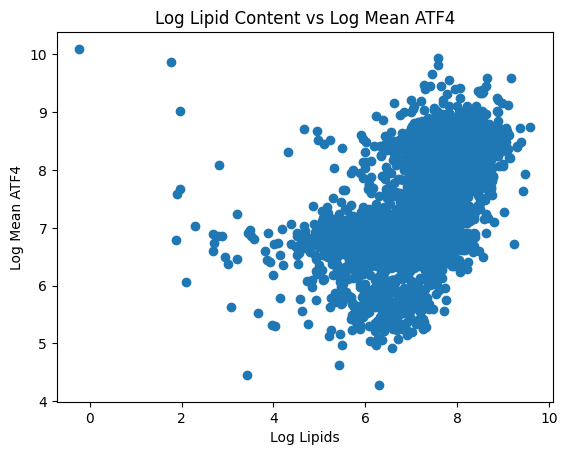

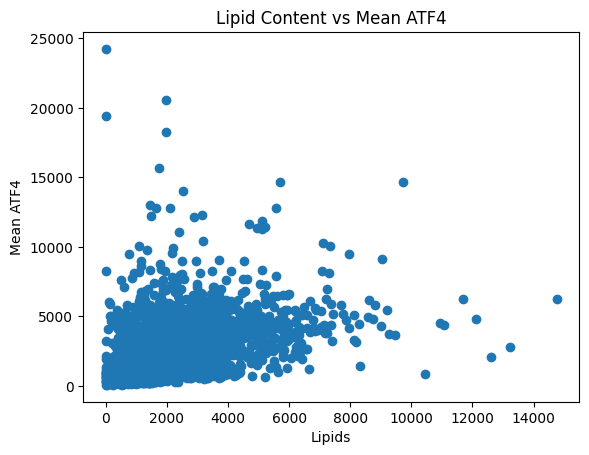

In [27]:
# Convert lists to DataFrame
data = pd.DataFrame({'Lipid Mean': lipid_mean_list, 'Mean ATF4': mean_ATF4_list})

# Now you can easily manipulate and analyze the data using pandas methods
# For example, you can calculate statistics:
print("Summary statistics:")
print(data.describe())

# Or you can perform transformations, such as logarithmic transformation:
data['Log Lipid Mean'] = np.log(data['Lipid Mean'])
data['Log Mean ATF4'] = np.log(data['Mean ATF4'])

# Finally, you can plot the transformed data or perform statistical tests:
# For example, you can plot the log-transformed data:
plt.scatter(data['Log Lipid Mean'], data['Log Mean ATF4'])
plt.xlabel('Log Lipids')
plt.ylabel('Log Mean ATF4')
plt.title('Log Lipid Content vs Log Mean ATF4')
plt.show()

plt.scatter(data['Lipid Mean'], data['Mean ATF4'])
plt.xlabel('Lipids')
plt.ylabel('Mean ATF4')
plt.title('Lipid Content vs Mean ATF4')
plt.show()

Summary statistics:
       Lipid Percent     Mean ATF4
count    3411.000000   3411.000000
mean        0.132332   1943.437269
std         0.100093   2013.611574
min         0.000000     72.477568
25%         0.063478    780.834751
50%         0.106325   1026.513476
75%         0.173076   2712.589533
max         0.783123  24237.009081


C:\Users\abockhughes\AppData\Local\anaconda3\envs\cellpose\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


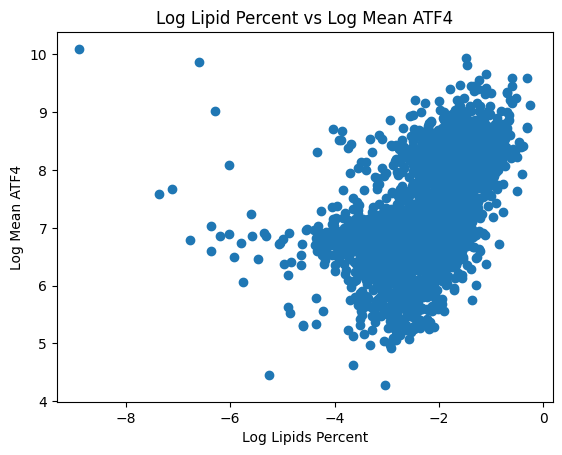

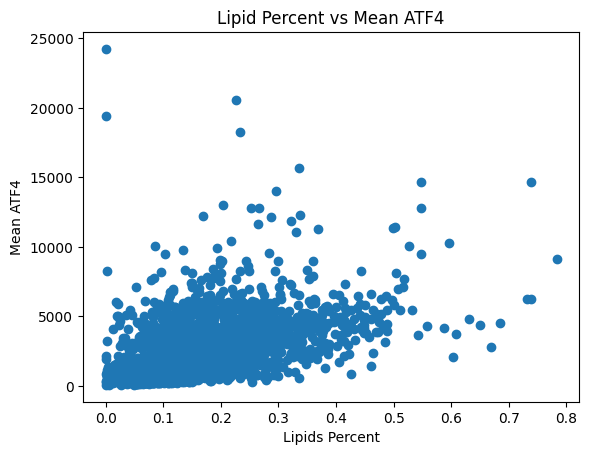

In [47]:
# Convert lists to DataFrame
data = pd.DataFrame({'Lipid Percent': lipid_percent_list, 'Mean ATF4': mean_ATF4_list})

# Now you can easily manipulate and analyze the data using pandas methods
# For example, you can calculate statistics:
print("Summary statistics:")
print(data.describe())

# Or you can perform transformations, such as logarithmic transformation:
data['Log Lipid Percent'] = np.log(data['Lipid Percent'])
data['Log Mean ATF4'] = np.log(data['Mean ATF4'])

# Finally, you can plot the transformed data or perform statistical tests:
# For example, you can plot the log-transformed data:
plt.scatter(data['Log Lipid Percent'], data['Log Mean ATF4'])
plt.xlabel('Log Lipids Percent')
plt.ylabel('Log Mean ATF4')
plt.title('Log Lipid Percent vs Log Mean ATF4')
plt.show()

plt.scatter(data['Lipid Percent'], data['Mean ATF4'])
plt.xlabel('Lipids Percent')
plt.ylabel('Mean ATF4')
plt.title('Lipid Percent vs Mean ATF4')
plt.show()

In [28]:
# Calculate Spearman's correlation coefficient and p-value
corr, p_value = spearmanr(data['Lipid Mean'], data['Mean ATF4'])

# Print the results
print("Spearman's correlation coefficient:", corr)
print("P-value:", p_value)

Spearman's correlation coefficient: 0.5493579689007579
P-value: 2.9191928800173115e-268


In [48]:
# Calculate Spearman's correlation coefficient and p-value
corr, p_value = spearmanr(data['Lipid Percent'], data['Mean ATF4'])

# Print the results
print("Spearman's correlation coefficient:", corr)
print("P-value:", p_value)

Spearman's correlation coefficient: 0.5541691786447245
P-value: 6.470249648272879e-274


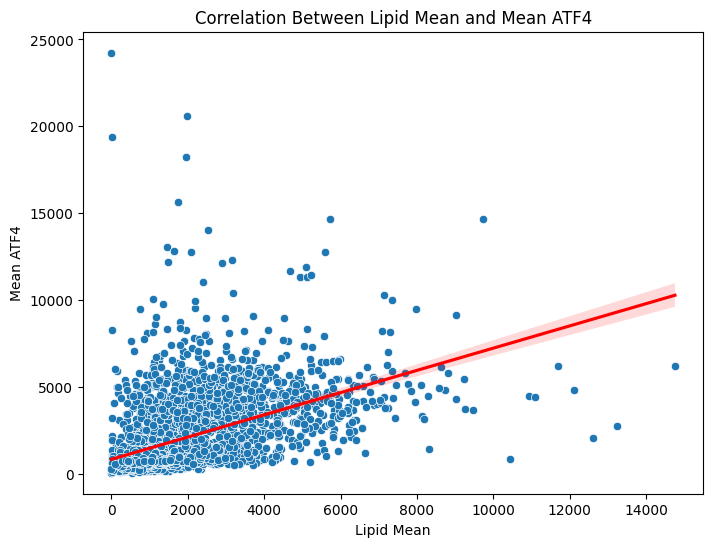

In [29]:
# Plot scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Lipid Mean', y='Mean ATF4', data=data)

# Add trend line (correlation curve)
sns.regplot(x='Lipid Mean', y='Mean ATF4', data=data, scatter=False, color='red')

# Add title and labels
plt.title("Correlation Between Lipid Mean and Mean ATF4")
plt.xlabel("Lipid Mean")
plt.ylabel("Mean ATF4")

# Show plot
plt.show()

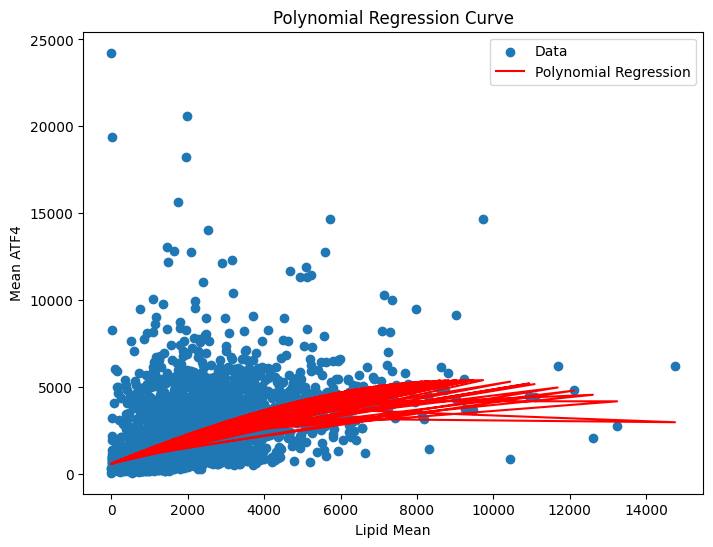

In [32]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Define your data: lipid content and ATF4 expression
x = data['Lipid Mean']  # Lipid content
y = data['Mean ATF4']   # ATF4 expression

# Polynomial features transformation
degree = 3  # Choose the degree of polynomial (e.g., 2 for quadratic, 3 for cubic)
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(x.values.reshape(-1, 1))

# Fit polynomial regression model
model = LinearRegression()
model.fit(X_poly, y)

# Predict y values using the model
y_pred = model.predict(X_poly)

# Plot the data and polynomial regression curve
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Data')
plt.plot(x, y_pred, 'r-', label='Polynomial Regression')
plt.xlabel('Lipid Mean')
plt.ylabel('Mean ATF4')
plt.title('Polynomial Regression Curve')
plt.legend()
plt.show()

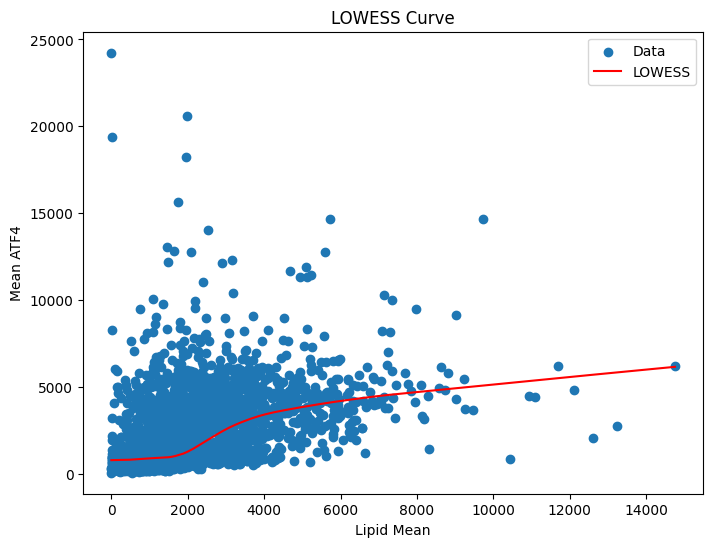

In [33]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Define your data: lipid content and ATF4 expression
x = data['Lipid Mean']  # Lipid content
y = data['Mean ATF4']   # ATF4 expression

# Fit a LOWESS curve
lowess = sm.nonparametric.lowess(y, x, frac=0.3)  # Adjust frac as needed (fraction of data used in each local regression)

# Plot the data and LOWESS curve
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Data')
plt.plot(lowess[:, 0], lowess[:, 1], 'r-', label='LOWESS')
plt.xlabel('Lipid Mean')
plt.ylabel('Mean ATF4')
plt.title('LOWESS Curve')
plt.legend()
plt.show()

C:\Users\abockhughes\AppData\Local\anaconda3\envs\cellpose\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


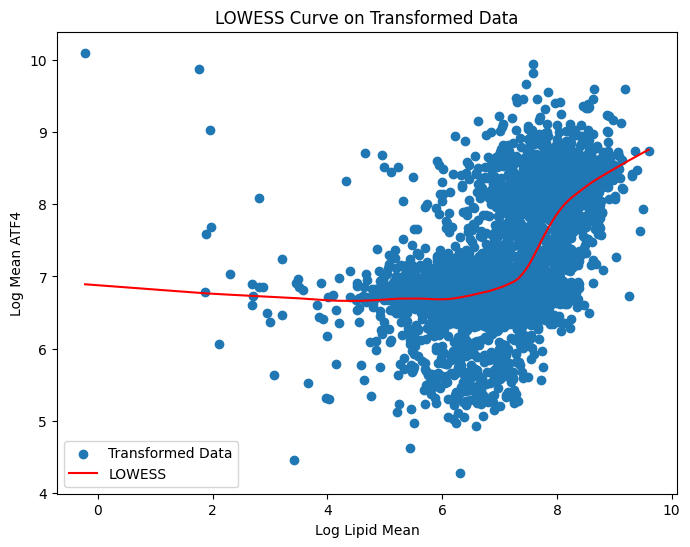

In [34]:
# Define your transformed data: log-transformed lipid content and ATF4 expression
x_transformed = np.log(data['Lipid Mean'])  # Transformed lipid content
y_transformed = np.log(data['Mean ATF4'])  # Transformed ATF4 expression

# Fit a LOWESS curve to the transformed data
lowess_transformed = sm.nonparametric.lowess(y_transformed, x_transformed, frac=0.3)  # Adjust frac as needed

# Plot the transformed data and LOWESS curve
plt.figure(figsize=(8, 6))
plt.scatter(x_transformed, y_transformed, label='Transformed Data')
plt.plot(lowess_transformed[:, 0], lowess_transformed[:, 1], 'r-', label='LOWESS')
plt.xlabel('Log Lipid Mean')
plt.ylabel('Log Mean ATF4')
plt.title('LOWESS Curve on Transformed Data')
plt.legend()
plt.show()

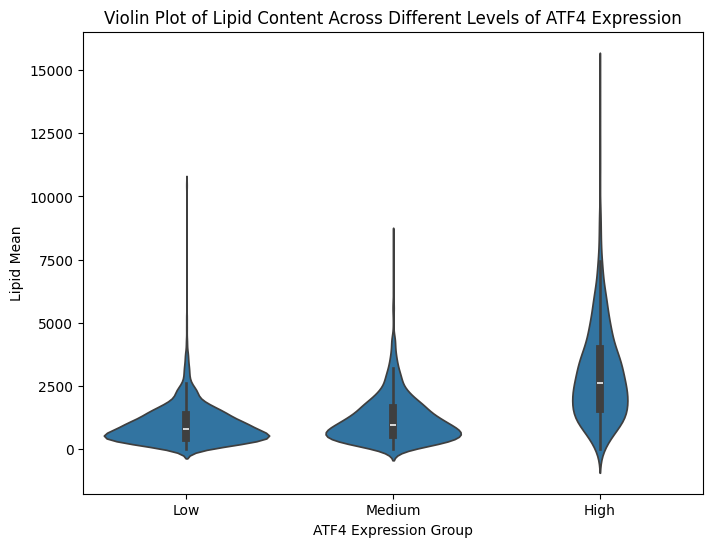

In [37]:
# Determine quantiles for dividing ATF4 expression into three groups
quantiles = data['Mean ATF4'].quantile([0, 0.33, 0.67, 1])

# Categorize ATF4 expression into three groups based on quantiles
data['ATF4 Group'] = pd.qcut(data['Mean ATF4'], q=[0, 1/3, 2/3, 1], labels=['Low', 'Medium', 'High'])

# Create violin plot with ATF4 expression groups
plt.figure(figsize=(8, 6))
sns.violinplot(x='ATF4 Group', y='Lipid Mean', data=data, order=['Low', 'Medium', 'High'])
plt.xlabel('ATF4 Expression Group')
plt.ylabel('Lipid Mean')
plt.title('Violin Plot of Lipid Content Across Different Levels of ATF4 Expression')
plt.show()